In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Imports

In [2]:
import math
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.applications import VGG16
from PIL import Image, ImagePath, ImageDraw
import pandas as pd
from os import path
from tqdm import tqdm
import json
import datetime
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import timeit
import pandas as pd
import joblib
import urllib.request
import imgaug.augmenters as iaa
from keras import legacy
from sklearn.model_selection import train_test_split
from keras.callbacks import Callback, ModelCheckpoint,TensorBoard,ReduceLROnPlateau
from keras.callbacks import TensorBoard
import time
import keras
from tensorflow.keras.models import Model, load_model
import segmentation_models as sm
from segmentation_models import Unet
from tensorflow.python.keras.callbacks import TensorBoard
tf.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `tf.keras` framework.


In [3]:
keras.config.disable_traceback_filtering()
sm.set_framework('tf.keras')
tf.config.optimizer.set_jit(False)

In [5]:
model = Unet('vgg16', encoder_weights='imagenet', classes=21, activation='softmax', input_shape=(256,256,3))

2024-11-06 21:30:48.838787: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-11-06 21:30:48.838804: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-06 21:30:48.838806: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-06 21:30:48.838820: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-06 21:30:48.838829: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Image Processing

In [7]:
train_image_dir = '/Users/vedanshkumar/Documents/Projects_sem5/AI/ImageSegmentation/Road_Segmentation/Datasets/IDD_Segmentation/leftImg8bit/train'
train_mask_dir = '/Users/vedanshkumar/Documents/Projects_sem5/AI/ImageSegmentation/Road_Segmentation/Datasets/IDD_Segmentation/gtFine/train'
val_image_dir = '/Users/vedanshkumar/Documents/Projects_sem5/AI/ImageSegmentation/Road_Segmentation/Datasets/IDD_Segmentation/leftImg8bit/val'
val_mask_dir = '/Users/vedanshkumar/Documents/Projects_sem5/AI/ImageSegmentation/Road_Segmentation/Datasets/IDD_Segmentation/gtFine/val'

In [8]:
train_image_list=[]
for i in sorted(os.listdir(train_image_dir)):
  # print(i)
  if i != '.DS_Store':
    folder_dir=os.path.join(train_image_dir,i)
    for image in sorted(os.listdir(folder_dir)):
      if image != '.DS_Store':
        image_directory=os.path.join(folder_dir,image)
        train_image_list.append(image_directory)

In [9]:
train_mask_list=[]
for i in sorted(os.listdir(train_mask_dir)):
  # print(i)
  if i != '.DS_Store':
    folder_dir=os.path.join(train_mask_dir,i)
    for mask in sorted(os.listdir(folder_dir)):
        if mask != '.DS_Store':
          mask_directory=os.path.join(folder_dir,mask)
          train_mask_list.append(mask_directory)

In [10]:
len(train_mask_list),len(train_image_list)

(6993, 6993)

# Pre Processing

### Train Dataset

In [11]:
train_df = pd.DataFrame({'images': train_image_list, 'json': train_mask_list})

In [12]:
len(train_df)

6993

In [13]:
def grader_1(data_df):
    for i in data_df.values:
        id_0 = i[0].split('/')[-1].split('_')[0]
        id_1 = i[1].split('/')[-1].split('_')[0]
        if not (path.isfile(i[0]) and path.isfile(i[1]) and id_0 == id_1):
            return False
    return True

In [14]:
grader_1(train_df)

True

In [15]:
train_df.shape

(6993, 2)

In [16]:
a = []
def return_unique_labels(data_df):
    for i in tqdm(data_df['json']):
      f = open(i,)
      data =json.load(f)
      for j in data['objects']:
        a.append((j.get('label')))
    return a

In [17]:
unique_labels = return_unique_labels(train_df)

100%|██████████| 6993/6993 [00:14<00:00, 486.38it/s]


In [18]:
def unique(list1): 
    list_set = set(list1) 
    unique_list = (list(list_set)) 
    return unique_list
unique_labels=unique(unique_labels)

In [19]:
len(unique_labels)

38

In [20]:
(unique_labels)

['caravan',
 'rider',
 'traffic sign',
 'sidewalk',
 'parking',
 'train',
 'fallback background',
 'billboard',
 'sky',
 'vegetation',
 'fence',
 'trailer',
 'road',
 'pole',
 'vehicle fallback',
 'motorcycle',
 'bridge',
 'polegroup',
 'license plate',
 'curb',
 'car',
 'drivable fallback',
 'out of roi',
 'traffic light',
 'obs-str-bar-fallback',
 'bicycle',
 'non-drivable fallback',
 'rectification border',
 'tunnel',
 'animal',
 'person',
 'rail track',
 'guard rail',
 'autorickshaw',
 'wall',
 'bus',
 'building',
 'truck']

In [21]:
label_clr = {
    'vehicle':90,
    'non-drivable fallback': 40,
    'animal': 50,
    'train': 200,
    'obs-str-bar-fallback': 130,
    'caravan': 90,
    'road': 10,
    'building': 140,
    'car': 80,
    'billboard': 120,
    'pole': 130,
    'truck': 90,
    'vegetation': 150,
    'tunnel': 140,
    'rider': 60,
    'trailer': 90,
    'guard rail': 110,
    'bus': 90,
    'bicycle': 70,
    'sidewalk': 30,
    'bridge': 140,
    'traffic light': 120,
    'rectification border': 190,
    'drivable fallback': 20,
    'person': 50,
    'autorickshaw': 80,
    'out of roi': 0,
    'fallback background': 160,
    'license plate': 200,
    'polegroup': 130,
    'parking': 20,
    'vehicle fallback': 90,
    'rail track': 40,
    'curb': 100,
    'motorcycle': 70,
    'traffic sign': 120,
    'sky': 160,
    'wall': 100,
    'fence': 110
}


In [22]:
len(label_clr.values())

39

In [23]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 38:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

Flase


In [24]:
def get_poly(file):
    f = open(file,)
    data = json.load(f)
    print(data)
    label,vertexlist=[],[]
    for obj in data['objects']:
        label.append(obj['label'])
        vertexlist.append([tuple(vertex) for vertex in obj['polygon']])
    w= data['imgWidth']
    h=data['imgHeight']
    return w, h, label, vertexlist

In [25]:
get_poly('/Users/vedanshkumar/Documents/Projects_sem5/AI/ImageSegmentation/Road_Segmentation/Datasets/IDD_Segmentation/gtFine/train/0/005506_gtFine_polygons.json')

{'imgHeight': 964, 'imgWidth': 1280, 'objects': [{'date': '13-Apr-2018 15:51:45', 'deleted': 0, 'draw': True, 'id': 37, 'label': 'vegetation', 'polygon': [[509.8076923076923, 491.2692307692308], [515.9871794871794, 491.2692307692308], [528.3461538461538, 495.3888888888889], [532.465811965812, 488.1794871794872], [538.6452991452992, 491.2692307692308], [545.8547008547008, 492.2991452991453], [549.974358974359, 486.11965811965814], [559.2435897435897, 486.11965811965814], [568.5128205128206, 484.05982905982904], [566.4529914529915, 493.3290598290598], [577.7820512820513, 492.2991452991453], [584.991452991453, 500.53846153846155], [583.9615384615385, 506.71794871794873], [582.9316239316239, 520.1068376068376], [574.6923076923077, 536.5854700854701], [561.3034188034188, 546.8846153846154], [535.5555555555555, 539.6752136752136], [512.8974358974359, 505.6880341880342], [509.8076923076923, 498.4786324786325]], 'user': 'cvit', 'verified': 0}, {'date': '13-Apr-2018 16:07:04', 'deleted': 0, 'dr

(1280,
 964,
 ['vegetation',
  'road',
  'road',
  'curb',
  'sky',
  'building',
  'building',
  'vegetation',
  'billboard',
  'obs-str-bar-fallback',
  'obs-str-bar-fallback',
  'pole',
  'obs-str-bar-fallback',
  'obs-str-bar-fallback',
  'vegetation',
  'car',
  'rider',
  'rider',
  'car',
  'rider',
  'pole',
  'vegetation',
  'curb',
  'rider',
  'motorcycle',
  'obs-str-bar-fallback',
  'obs-str-bar-fallback',
  'obs-str-bar-fallback',
  'obs-str-bar-fallback',
  'obs-str-bar-fallback',
  'obs-str-bar-fallback',
  'vegetation',
  'pole',
  'billboard',
  'vegetation',
  'pole',
  'obs-str-bar-fallback',
  'obs-str-bar-fallback',
  'pole',
  'autorickshaw',
  'car',
  'rider',
  'rider',
  'motorcycle',
  'obs-str-bar-fallback',
  'motorcycle',
  'obs-str-bar-fallback',
  'sky',
  'sky',
  'vegetation',
  'pole',
  'pole',
  'obs-str-bar-fallback',
  'pole',
  'obs-str-bar-fallback',
  'obs-str-bar-fallback',
  'obs-str-bar-fallback',
  'obs-str-bar-fallback',
  'obs-str-bar-fa

In [26]:
def compute_masks(data_df):
    mask=[]
    for file in tqdm(data_df['json']):
        w, h, labels, vertexlist = get_poly(file)

        img= Image.new("RGB",(w,h)) 
        img1 = ImageDraw.Draw(img)
        for i in range(len(labels)):
            if(len(vertexlist[i])>1):
                img1.polygon(vertexlist[i], fill = label_clr[labels[i]])
        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        new_file=file.replace('gtFine','Masks')
        new_file=new_file.replace('json','png')
        # print(file.split('/')[12])
        os.makedirs('/Users/vedanshkumar/Documents/Projects_sem5/AI/ImageSegmentation/Road_Segmentation/Datasets/IDD_Segmentation/Masks/train/'+file.split('/')[12],exist_ok=True)
        im.save(new_file)
        mask.append(new_file)
    data_df['mask']=mask
    
    return data_df

In [27]:
# data_df = compute_masks(train_df)

In [28]:
# data_df.head()


In [29]:
# joblib.dump(data_df,'/Users/vedanshkumar/Documents/Projects_sem5/AI/ImageSegmentation/Road_Segmentation/Datasets/IDD_Segmentation/train_meta.pkl')

In [30]:
train_df = joblib.load('/Users/vedanshkumar/Documents/Projects_sem5/AI/ImageSegmentation/Road_Segmentation/Datasets/IDD_Segmentation/train_meta.pkl')

In [31]:
train_df.head(1)

images  \
0  /Users/vedanshkumar/Documents/Projects_sem5/AI...   

                                                json  \
0  /Users/vedanshkumar/Documents/Projects_sem5/AI...   

                                                mask  
0  /Users/vedanshkumar/Documents/Projects_sem5/AI...

### Validation dataset

In [32]:
val_image_list=[]
for i in sorted(os.listdir(val_image_dir)):
  # print(i)
  if i != '.DS_Store':
    folder_dir=os.path.join(val_image_dir,i)
    for image in sorted(os.listdir(folder_dir)):
      if image != '.DS_Store':
        image_directory=os.path.join(folder_dir,image)
        val_image_list.append(image_directory)

In [33]:
val_mask_list=[]
for i in sorted(os.listdir(val_mask_dir)):
  # print(i)
  if i != '.DS_Store':
    folder_dir=os.path.join(val_mask_dir,i)
    for mask in sorted(os.listdir(folder_dir)):
        if mask != '.DS_Store':
          mask_directory=os.path.join(folder_dir,mask)
          val_mask_list.append(mask_directory)

In [34]:
len(val_image_list),len(val_mask_list)

(981, 981)

In [35]:
val_df = pd.DataFrame({'images': val_image_list, 'json': val_mask_list})


In [36]:
grader_1(val_df)

True

In [37]:
unique_labels_val = return_unique_labels(val_df)

100%|██████████| 981/981 [00:02<00:00, 457.62it/s]


In [38]:
unique_labels_val = unique(unique_labels_val)

In [39]:
len(unique_labels_val)

39

In [40]:
for i in unique_labels_val:
    if i not in unique_labels:
        unique_labels_val.remove(i)

In [41]:
def compute_masks_val(data_df):
    mask=[]
    for file in tqdm(data_df['json']):
        w, h, labels, vertexlist = get_poly(file)

        img= Image.new("RGB",(w,h)) 
        img1 = ImageDraw.Draw(img)
        for i in range(len(labels)):
            if(len(vertexlist[i])>1):
                if labels[i] == 'ego vehicle':
                    print(i)
                    labels[i] = 'vehicle'
                img1.polygon(vertexlist[i], fill = label_clr[labels[i]])
        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        new_file=file.replace('gtFine','Masks')
        new_file=new_file.replace('json','png')
        # print(file.split('/')[12])
        os.makedirs('/Users/vedanshkumar/Documents/Projects_sem5/AI/ImageSegmentation/Road_Segmentation/Datasets/IDD_Segmentation/Masks/val/'+file.split('/')[12],exist_ok=True)
        im.save(new_file)
        mask.append(new_file)
    data_df['mask']=mask
    
    return data_df

In [42]:
# val_df = compute_masks_val(val_df)

In [43]:
# joblib.dump(val_df,'/Users/vedanshkumar/Documents/Projects_sem5/AI/ImageSegmentation/Road_Segmentation/Datasets/IDD_Segmentation/val_meta.pkl')

In [44]:
val_df = joblib.load('/Users/vedanshkumar/Documents/Projects_sem5/AI/ImageSegmentation/Road_Segmentation/Datasets/IDD_Segmentation/val_meta.pkl')

# Model

In [45]:


def unet_vgg16(input_shape=(256, 256, 3), classes=21):
    # Encoder
    base_model = tf.keras.applications.VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

    # Encoder layers
    c1 = base_model.get_layer('block1_conv2').output  # 256x256
    c2 = base_model.get_layer('block2_conv2').output  # 128x128
    c3 = base_model.get_layer('block3_conv3').output  # 64x64
    c4 = base_model.get_layer('block4_conv3').output  # 32x32
    p5 = base_model.get_layer('block5_conv3').output  # 16x16

    # Decoder
    u6 = layers.UpSampling2D((2, 2))(p5)  # 32x32
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.ReLU()(c6)
    c6 = layers.Conv2D(512, (3, 3), padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.ReLU()(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)  # 64x64
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.ReLU()(c7)
    c7 = layers.Conv2D(256, (3, 3), padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.ReLU()(c7)

    u8 = layers.UpSampling2D((2, 2))(c7)  # 128x128
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.ReLU()(c8)
    c8 = layers.Conv2D(128, (3, 3), padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.ReLU()(c8)

    u9 = layers.UpSampling2D((2, 2))(c8)  # 256x256
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.ReLU()(c9)
    c9 = layers.Conv2D(64, (3, 3), padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.ReLU()(c9)

    outputs = layers.Conv2D(classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=base_model.input, outputs=outputs)

    return model


In [46]:
# model = unet_vgg16(input_shape=(256, 256, 3), classes=19)
model = Unet('vgg16', encoder_weights='imagenet', classes=19, activation='softmax', input_shape=(256,256,3))

In [47]:
X_train = train_df
X_test = val_df

In [48]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [49]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()

In [50]:
class Dataset():
    def __init__(self , basepath , images_file_names , mask_file_names , CLASSES):
        self.image_ids = images_file_names
        self.mask_ids = mask_file_names     
        self.images_fps   = [image_id for image_id in self.image_ids]
        self.masks_fps    = [mask_id for mask_id in self.mask_ids]
        self.CLASSES= CLASSES
        self.class_values = CLASSES
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED) 
        image = cv2.resize(image,(256,256),interpolation=cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = cv2.resize(mask,(256,256))
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')

        if self.images_fps[i] in X_train:
          a = np.random.uniform()
          if a<0.2:
              image = aug2.augment_image(image)
              image_mask = aug2.augment_image(image_mask)
          elif a<0.4:
              image = aug3.augment_image(image)
              image_mask = aug3.augment_image(image_mask)
          elif a<0.6:
              image = aug4.augment_image(image)
              image_mask = aug4.augment_image(image_mask)
          elif a<0.8:
              image = aug5.augment_image(image)
              image_mask = image_mask
          else:
              image = aug6.augment_image(image)
              image_mask = aug6.augment_image(image_mask)
        # image = image.astype('float32')      
        return image, image_mask
        
    def __len__(self):
        return len(self.image_ids)
   

In [51]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=8, shuffle=False):
        # super.__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [52]:
import tensorflow as tf

def custom_iou_score(y_true, y_pred, threshold=0.5, smooth=1e-5):
    """
    Custom IoU metric with threshold for binary and multi-class segmentation.
    
    Parameters:
    - y_true: Ground truth mask.
    - y_pred: Predicted mask (usually a probability map).
    - threshold: Threshold to binarize y_pred for IoU calculation.
    - smooth: Smoothing constant to avoid division by zero.
    
    Returns:
    - IoU score as a tensor.
    """
    # Apply threshold to predictions
    y_pred = tf.cast(y_pred > threshold, dtype=tf.float32)
    
    # Flatten the tensors to compute the intersection and union over all pixels
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    y_pred = tf.cast(y_pred,tf.float32)
    y_true = tf.cast(y_true,tf.float32)
    # Compute the intersection and union
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    # Calculate IoU with smoothing
    iou = (intersection + smooth) / (union + smooth)
    return iou


In [53]:
optim = tf.keras.optimizers.Adam(0.001)
focal_loss = sm.losses.dice_loss
iou_score = sm.metrics.IOUScore(threshold = 0.5)
# iou_score = custom_iou_score()
model.compile(optim, focal_loss, metrics=[iou_score])

In [54]:
def ensure_float32(dataset):
    return dataset.map(
        lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32))
    )

In [55]:
CLASSES = list(np.unique(list(label_clr.values())))

In [56]:
CLASSES = CLASSES
log_dir = '/Users/vedanshkumar/Documents/Projects_sem5/AI/Final_Segmentation/tensorboard/logs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
basepath = '/Users/vedanshkumar/Documents/Projects_sem5/AI/Final_Segmentation/tensorboard/'
train_dataset = Dataset(basepath, X_train['images'].values, X_train['mask'].values, CLASSES=CLASSES)
test_dataset = Dataset(basepath, X_test['images'].values, X_test['mask'].values, CLASSES=CLASSES)
train_dataloader = Dataloder(train_dataset, batch_size=4, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=4, shuffle=True)
print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)
# assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
# assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, 21)
tensorboard = TensorBoard(log_dir="/Users/vedanshkumar/Documents/Projects_sem5/AI/Final_Segmentation/tensorboard/logs/".format(time.time()), histogram_freq=1, write_graph=True)
checkpoint = ModelCheckpoint('/Users/vedanshkumar/Documents/Projects_sem5/AI/Final_Segmentation/tensorboard/best/best_model.weights.h5', save_weights_only=True,save_best_only=True, mode='min', monitor='val_iou_score')
red = ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
call = [tensorboard_callback]

(4, 256, 256, 3)
(4, 256, 256, 19)


2024-11-06 21:31:06.896056: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-06 21:31:06.896082: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-06 21:31:06.896555: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-11-06 21:31:06.896676: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-06 21:31:06.896678: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-06 21:31:06.896695: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


In [57]:
len(train_dataloader),len(test_dataloader)

(1748, 245)

In [58]:
model_path = '/Users/vedanshkumar/Documents/Projects_sem5/AI/Final_Segmentation/best_model.keras'
csv_path = '//Users/vedanshkumar/Documents/Projects_sem5/AI/Final_Segmentation/scores.csv'

In [59]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        CSVLogger(csv_path,append=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ]

In [60]:
# model.fit(train_dataloader, epochs=1, verbose = 1, validation_data=test_dataloader, callbacks=callbacks)

In [61]:
# model.fit(train_dataloader, epochs=1, verbose = 1, validation_data=test_dataloader, callbacks=callbacks)

In [62]:
# model.fit(train_dataloader, epochs=1, verbose = 1, validation_data=test_dataloader, callbacks=callbacks)

In [63]:
# history = model.fit(train_dataloader, epochs=1, verbose = 1, validation_data=test_dataloader, callbacks=callbacks)

In [64]:
model.load_weights('/Users/vedanshkumar/Documents/Projects_sem5/AI/Final_Segmentation/model_segmentation_sm_score_1556.keras')

/Users/vedanshkumar/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 130 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


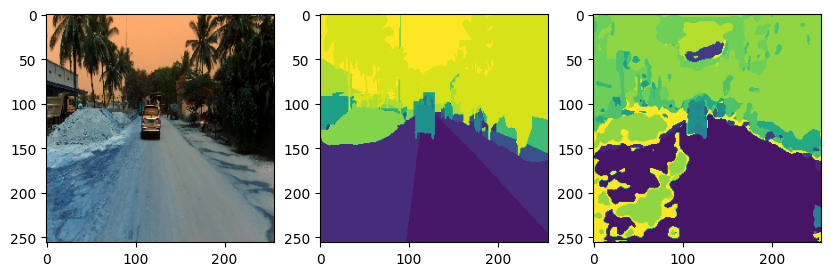

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


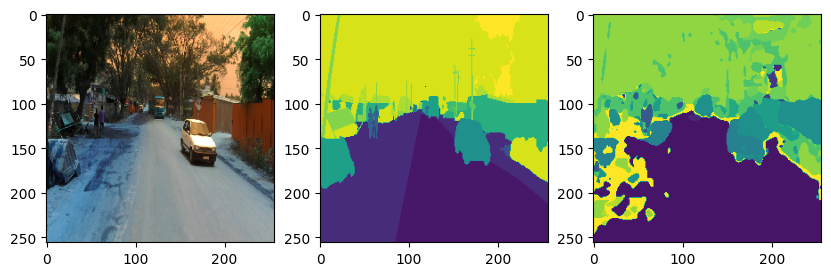

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


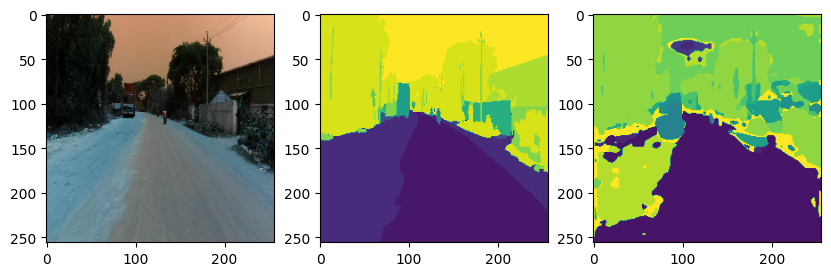

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


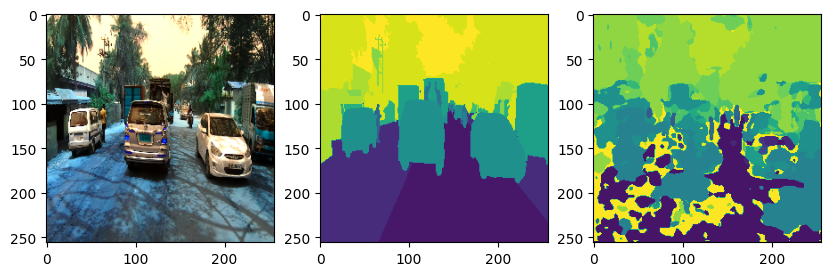

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


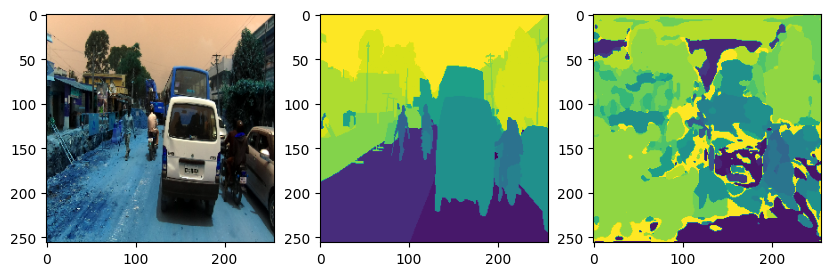

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


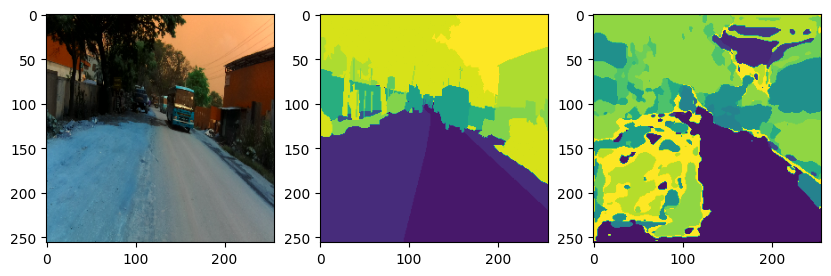

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


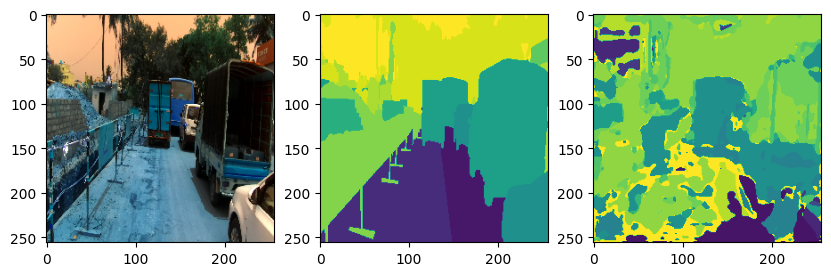

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


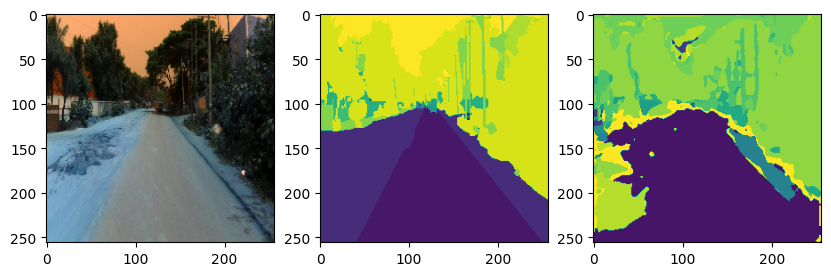

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


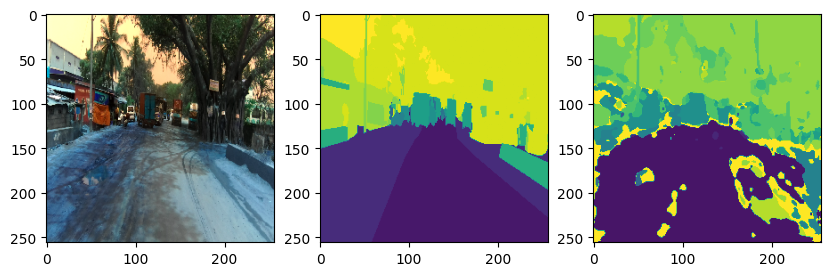

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


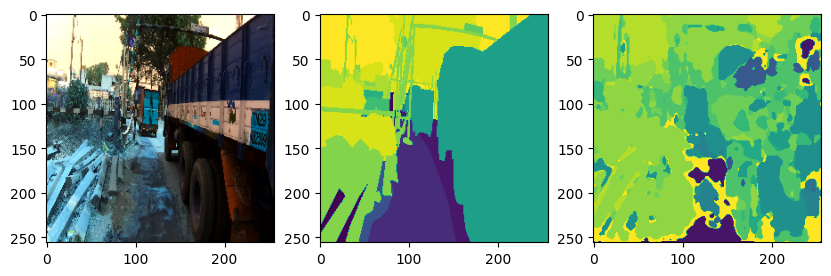

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


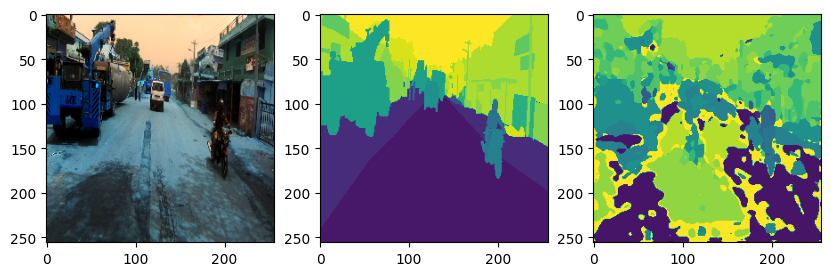

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


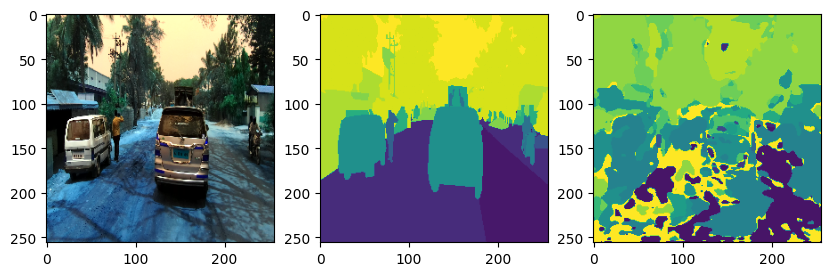

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


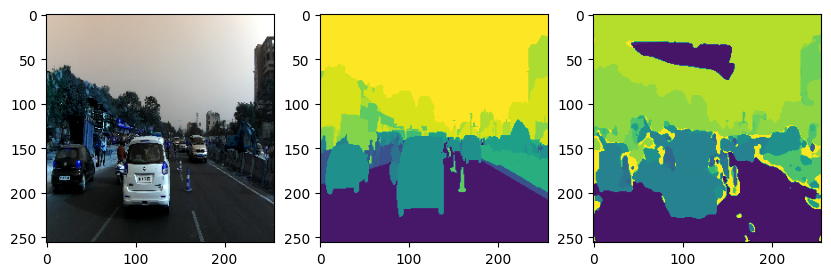

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


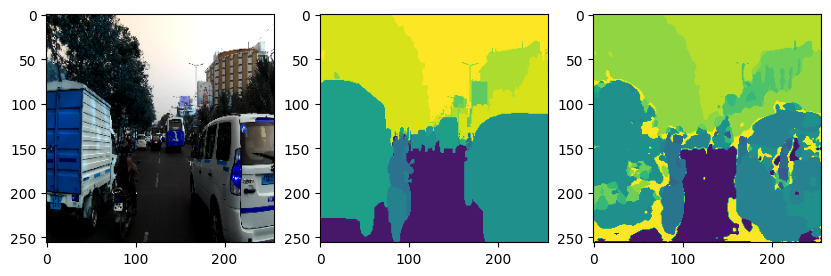

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


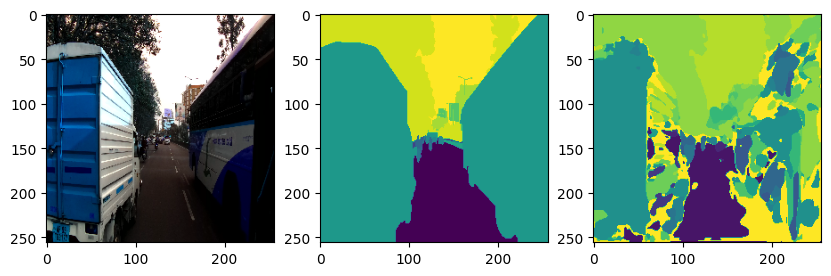

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


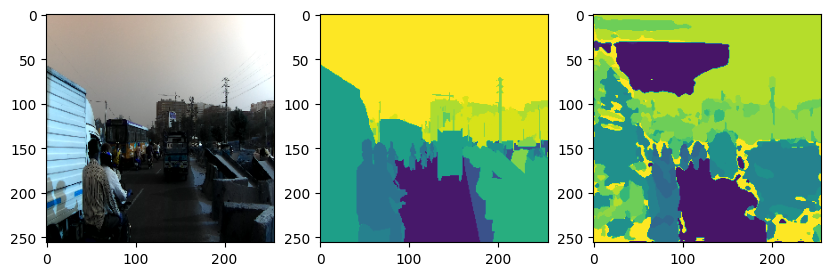

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


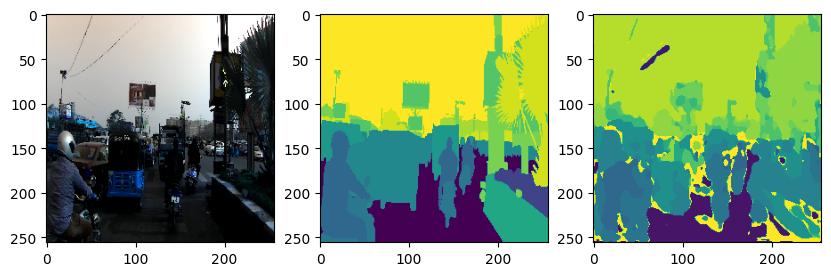

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


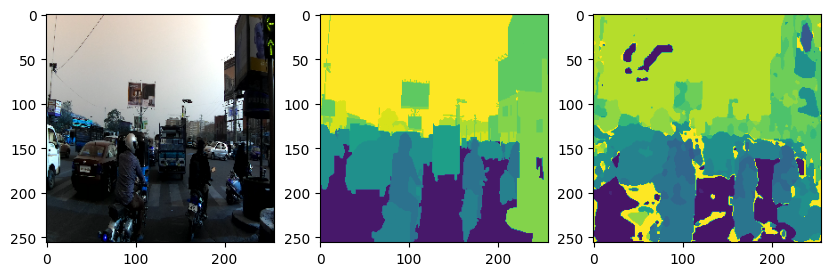

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


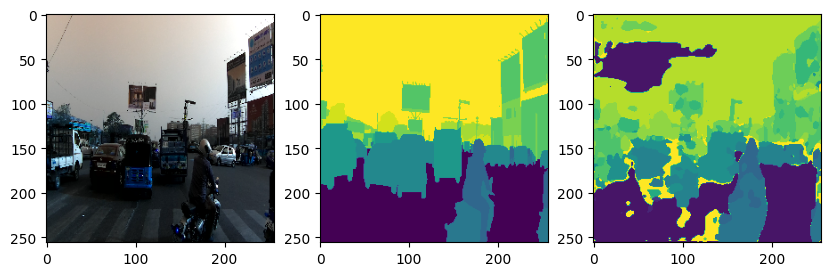

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


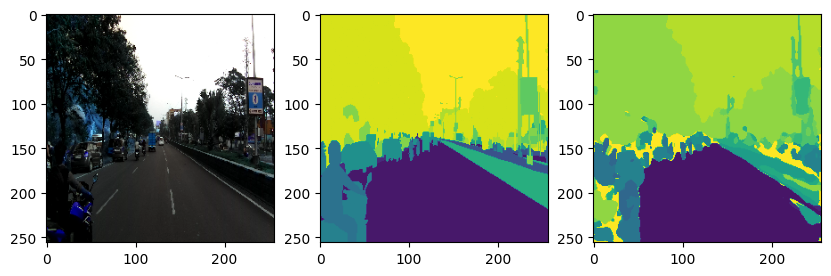

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


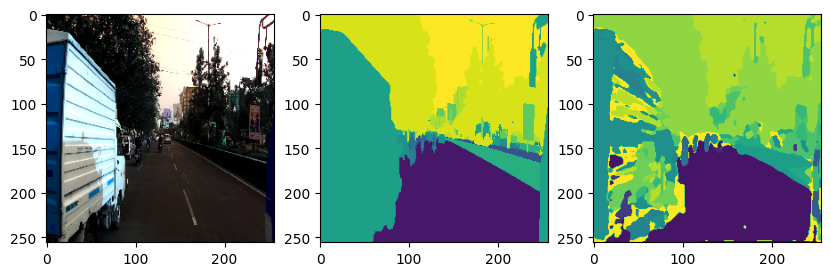

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


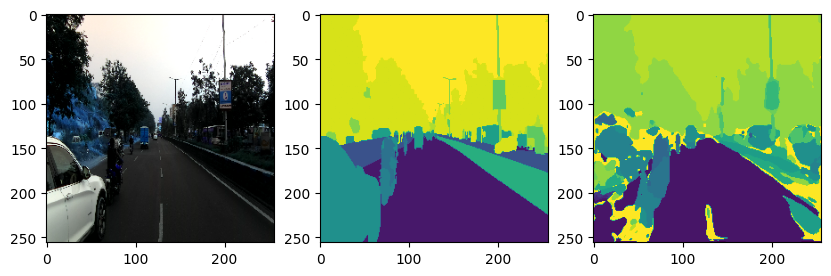

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


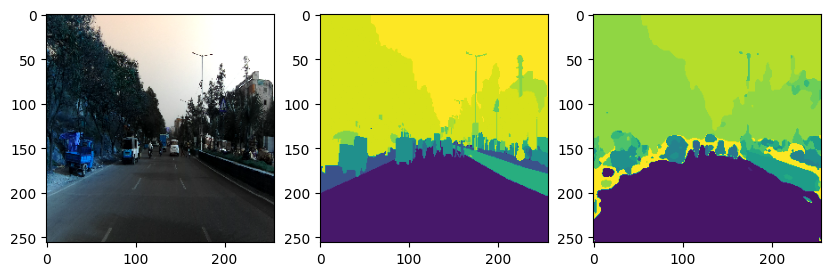

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


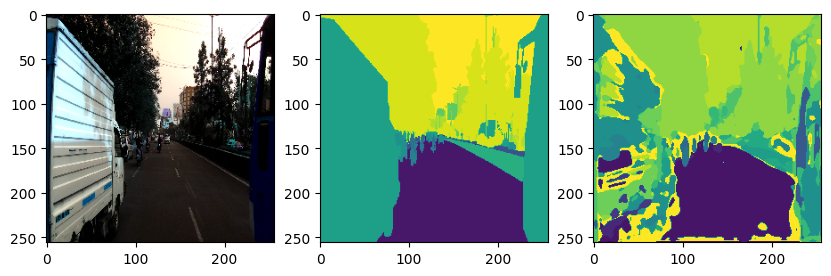

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


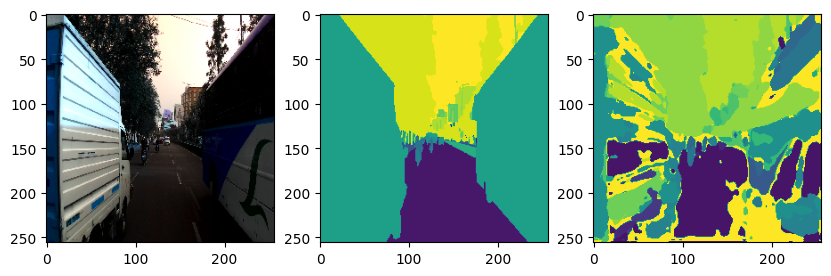

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


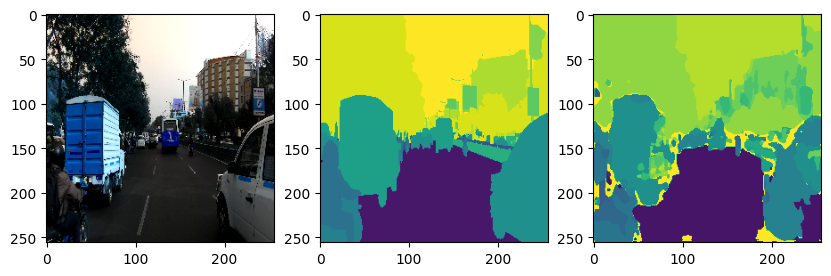

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


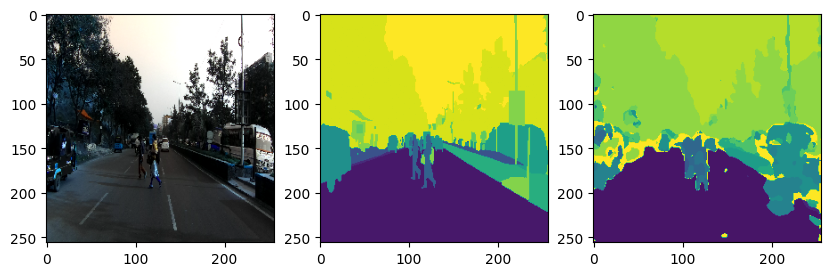

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


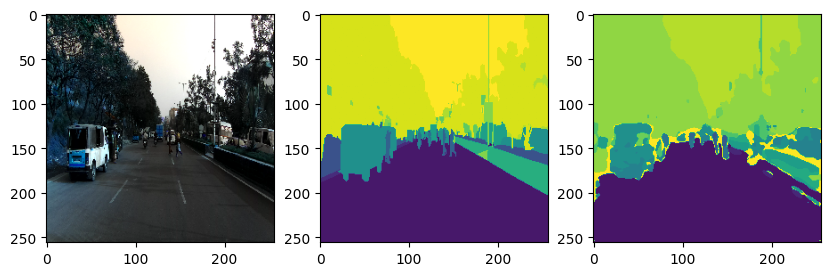

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


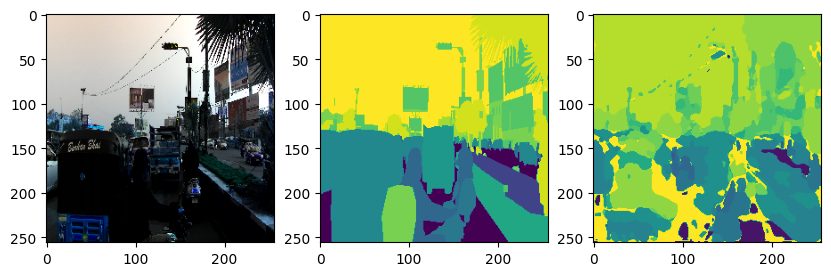

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


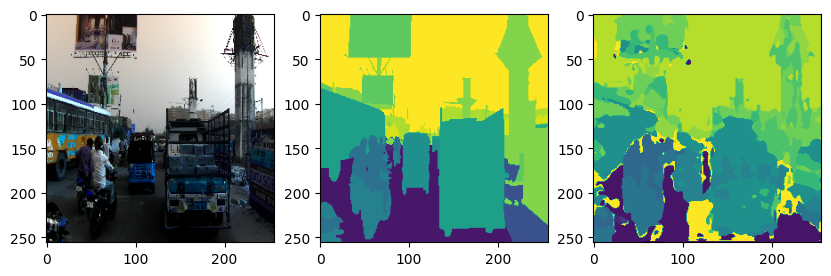

In [67]:
a=0
for i in range(len(X_test)):
    a+=1
    #original image
    image = cv2.imread(list(X_test['images'])[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,256),interpolation = cv2.INTER_NEAREST) 
    
    #predicted segmentation map
    pred_mask  = model.predict(image[np.newaxis,:,:,:])
    pred_mask = tf.argmax(pred_mask, axis=-1)
    
    #original segmentation map
    image_mask = cv2.imread(list(X_test['mask'])[i], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256),interpolation = cv2.INTER_NEAREST)
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask) 
    plt.subplot(133)
    plt.imshow(pred_mask[0])
    plt.show()
    if a==30:
      break

In [ ]:
model.save('/Users/vedanshkumar/Documents/Projects_sem5/AI/Final_Segmentation/model_segmentation_sm_score_last.keras')

## Results

In [1]:
import pandas

In [2]:
df = pandas.read_csv('/Users/vedanshkumar/Documents/Projects_sem5/AI/Final_Segmentation/scores.csv')

In [3]:
df

epoch  iou_score      loss  val_iou_score  val_loss
0      0   0.295333  0.747691       0.329660  0.703382
1      1   0.344244  0.663359       0.298692  0.672887
2      2   0.333989  0.582489       0.328986  0.588559
3      3   0.353146  0.557863       0.339769  0.576349